In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.preprocessing import LabelEncoder,scale
from sklearn.model_selection import GridSearchCV
# from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier

# using SMOTE to fix imbalance problem
from imblearn.over_sampling import SMOTE
# using random undersampling to fix imbalance problem
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
raw_data = pd.read_csv('cleaned_US_Accidents.csv')
raw_data = raw_data.iloc[:,1:]
raw_data.head()

ID  Severity           Start_Time             End_Time  Start_Lat  \
0   A-1         3  2016-02-08 00:37:08  2016-02-08 06:37:08  40.108910   
1   A-5         3  2016-02-08 07:53:43  2016-02-08 13:53:43  39.172393   
2   A-8         2  2016-02-08 11:51:46  2016-02-08 17:51:46  41.375310   
3  A-10         2  2016-02-08 15:16:43  2016-02-08 21:16:43  40.109310   
4  A-11         2  2016-02-08 15:43:50  2016-02-08 21:43:50  39.192880   

   Start_Lng    End_Lat    End_Lng  Distance(mi)       Street  ... No_Exit  \
0 -83.092860  40.112060 -83.031870         3.230  Outerbelt E  ...   False   
1 -84.492792  39.170476 -84.501798         0.500       I-75 S  ...   False   
2 -81.820170  41.367860 -81.821740         0.521       I-71 S  ...   False   
3 -82.968490  40.110780 -82.984000         0.826  Outerbelt W  ...   False   
4 -84.477230  39.196150 -84.473350         0.307       I-75 N  ...   False   

  Railway Roundabout Station   Stop  Traffic_Calming  Traffic_Signal  \
0   False      False   False  False            False           False   
1   False      False   False  False            False           False   
2   False      False   False  False            False           False   
3   False      False   False  False            False           False   
4   False      False   False  False            False           False   

   Sunrise_Sunset  Duration Duration(min)  
0           Night     360.0         360.0  
1             Day     360.0         360.0  
2             Day     360.0         360.0  
3             Day     360.0         360.0  
4             Day     360.0         360.0  

[5 rows x 37 columns]

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081305 entries, 0 to 2081304
Data columns (total 37 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ID                 object 
 1   Severity           int64  
 2   Start_Time         object 
 3   End_Time           object 
 4   Start_Lat          float64
 5   Start_Lng          float64
 6   End_Lat            float64
 7   End_Lng            float64
 8   Distance(mi)       float64
 9   Street             object 
 10  Side               object 
 11  City               object 
 12  County             object 
 13  State              object 
 14  Zipcode            object 
 15  Temperature(F)     float64
 16  Humidity(%)        float64
 17  Pressure(in)       float64
 18  Visibility(mi)     float64
 19  Wind_Direction     object 
 20  Wind_Speed(mph)    float64
 21  Precipitation(in)  float64
 22  Weather_Condition  object 
 23  Amenity            bool   
 24  Crossing           bool   
 25  Give_Way          

In [ ]:
model_data = raw_data.drop(['ID','Street','Start_Time','End_Time','Start_Lat','Start_Lng','End_Lat','End_Lng','Street','City','County',
                           'Zipcode','Wind_Direction','Weather_Condition','Duration','Duration(min)','Distance(mi)'],axis=1)

In [ ]:
model_data = model_data.replace([True, False], [1,0])
model_data.rename(columns = {'Sunrise_Sunset':'Sunset_or_not','Side':'Side_L'}, inplace = True)
model_data = model_data.replace(['Night', 'Day'], [1,0])
model_data['Side_L'] = model_data['Side_L'].replace(['L','R'],[1,0])

In [ ]:
model_data['State'] = model_data['State'].astype('category')
model_data = pd.get_dummies(model_data, columns=['State'], drop_first=True)
state_col = model_data.columns[22:]
model_data[state_col] = model_data[state_col].astype('int64')

In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081305 entries, 0 to 2081304
Data columns (total 68 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Side_L             int64  
 2   Temperature(F)     float64
 3   Humidity(%)        float64
 4   Pressure(in)       float64
 5   Visibility(mi)     float64
 6   Wind_Speed(mph)    float64
 7   Precipitation(in)  float64
 8   Amenity            int64  
 9   Crossing           int64  
 10  Give_Way           int64  
 11  Junction           int64  
 12  No_Exit            int64  
 13  Railway            int64  
 14  Roundabout         int64  
 15  Station            int64  
 16  Stop               int64  
 17  Traffic_Calming    int64  
 18  Traffic_Signal     int64  
 19  Sunset_or_not      int64  
 20  State_AR           uint8  
 21  State_AZ           uint8  
 22  State_CA           int64  
 23  State_CO           int64  
 24  State_CT           int64  
 25  State_DC          

In [ ]:
scale_col = ["Temperature(F)","Humidity(%)","Pressure(in)","Visibility(mi)",
             "Wind_Speed(mph)","Precipitation(in)"]

# First we try not to deal with imbalance problem

## Logistic Regression (multi-class)

Split train and test set

In [ ]:
train, test = train_test_split(model_data, test_size = 0.3, random_state=42)
x_train = train.iloc[0:,1:]
y_train = train['Severity']
x_test = test.iloc[0:,1:]
y_test = test['Severity']

In [ ]:
y_test.value_counts() / len(y_test)

2    0.934224
3    0.027955
4    0.027874
1    0.009947
Name: Severity, dtype: float64

In [ ]:
# scale the continuous numerical data
x_train[scale_col] = (x_train[scale_col] - x_train[scale_col].mean(axis=0))/ x_train[scale_col].std(axis=0)

In [ ]:
x_test[scale_col] = (x_test[scale_col] - x_test[scale_col].mean(axis=0))/ x_test[scale_col].std(axis=0)

Try a few logistic regression...

In [ ]:
lr_1 = LogisticRegression(penalty='elasticnet',class_weight=None,solver='saga',multi_class='multinomial',l1_ratio=0.5)
lr_1.fit(x_train, y_train)

D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(l1_ratio=0.5, multi_class='multinomial',
                   penalty='elasticnet', solver='saga')

In [ ]:
print(classification_report(y_test, lr_1.predict(x_test)))

              precision    recall  f1-score   support

           1       0.64      0.03      0.05      6211
           2       0.94      1.00      0.97    583322
           3       0.50      0.08      0.13     17455
           4       0.58      0.01      0.01     17404

    accuracy                           0.93    624392
   macro avg       0.66      0.28      0.29    624392
weighted avg       0.91      0.93      0.91    624392



In [ ]:
coefs_lr1 = pd.DataFrame(lr_1.coef_, columns = model_data.columns[1:])
coefs_lr1.insert(loc=0, column="Intercept", value=lr_1.intercept_)
coefs_lr1

Intercept    Side_L  Temperature(F)  Humidity(%)  Pressure(in)  \
0  -2.401054 -0.002612        0.091476    -0.000002      0.133394   
1   3.099873  0.057816       -0.150222    -0.065232     -0.061620   
2  -0.373536 -0.457843        0.148766     0.024643      0.046596   
3  -0.325284  0.398255       -0.090024     0.024396     -0.118298   

   Visibility(mi)  Wind_Speed(mph)  Precipitation(in)   Amenity  Crossing  \
0        0.102977         0.092669           0.034450 -0.059345  0.503943   
1        0.000006        -0.092453          -0.007914  0.107240 -0.009997   
2       -0.061055         0.071979           0.028171 -0.101144 -0.242107   
3       -0.041458        -0.071996          -0.055034  0.054011 -0.196068   

   ...  State_SD  State_TN  State_TX  State_UT  State_VA  State_VT  State_WA  \
0  ... -0.001206  1.806461 -2.590682 -0.132958  0.834937 -0.009566  0.786019   
1  ... -0.214322 -0.162973  0.884867 -0.112344 -0.294954 -0.525358 -0.961784   
2  ... -0.114912 -1.018961  1.472452  0.342443 -0.615492 -0.002068  0.224733   
3  ...  0.386221 -0.586096  0.193707 -0.061868  0.068175  0.592001 -0.058061   

   State_WI  State_WV  State_WY  
0 -0.038651 -0.415351  0.000000  
1 -2.167070  0.363978 -0.979666  
2  1.194489 -0.323417  0.116401  
3  1.011233  0.378048  0.844884  

[4 rows x 68 columns]

In [ ]:
lr_2 = LogisticRegression(penalty='elasticnet',C=10**-2,solver='saga',multi_class='multinomial',l1_ratio=0.5,max_iter=200)
lr_2.fit(x_train, y_train)

LogisticRegression(C=0.01, l1_ratio=0.5, max_iter=200,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')

In [ ]:
print(classification_report(y_test, lr_2.predict(x_test)))

              precision    recall  f1-score   support

           1       0.64      0.02      0.04      6211
           2       0.94      1.00      0.97    583322
           3       0.52      0.07      0.12     17455
           4       0.61      0.00      0.00     17404

    accuracy                           0.93    624392
   macro avg       0.68      0.27      0.28    624392
weighted avg       0.91      0.93      0.91    624392



For the non-converge problem, we have tried increasing max-iter parameter to 500 but it still cannot converge. Maybe the solution is wondering around the optimal solution or the model just cannot converge.  
It seems that the accuracy does not seem to do much better than just predicting severity 2. Try grid search to find best parameters of logistic regression...

In [ ]:
lr_3 = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2'],
        'multi_class':['multinomial'],
       'solver':['saga']}
lr_grid = GridSearchCV(lr_3, grid, cv=5, scoring='accuracy')
lr_grid.fit(x_train, y_train)

D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'multi_class': ['multinomial'],
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             scoring='accuracy')

In [ ]:
y_lrgird_pred = lr_grid.predict(x_test)
print(classification_report(y_test, y_lrgird_pred))
df_confusion = pd.crosstab(y_test, y_lrgird_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
display(df_confusion)

              precision    recall  f1-score   support

           1       0.64      0.03      0.05      6211
           2       0.94      1.00      0.97    583322
           3       0.50      0.08      0.13     17455
           4       0.57      0.01      0.01     17404

    accuracy                           0.93    624392
   macro avg       0.66      0.28      0.29    624392
weighted avg       0.91      0.93      0.91    624392



Predicted    1       2     3    4     All
Actual                                   
1          166    6004    40    1    6211
2           82  582092  1098   50  583322
3            1   16054  1354   46   17455
4            9   17074   194  127   17404
All        258  621224  2686  224  624392

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_lrgird_pred)

0.9348918628041358

In [ ]:
coef = lr_grid.best_estimator_.coef_
intercept = lr_grid.best_estimator_.intercept_
coefs_grid1 = pd.DataFrame(coef, columns = model_data.columns[1:])
coefs_grid1.insert(loc=0, column="Intercept", value=intercept)
coefs_grid1

Intercept    Side_L  Temperature(F)  Humidity(%)  Pressure(in)  \
0  -2.403951 -0.001799        0.091112     0.004189      0.133441   
1   3.106269  0.058989       -0.150271    -0.061250     -0.061683   
2  -0.376195 -0.456776        0.149087     0.028695      0.046685   
3  -0.326122  0.399587       -0.089928     0.028366     -0.118443   

   Visibility(mi)  Wind_Speed(mph)  Precipitation(in)   Amenity  Crossing  \
0        0.102955         0.092825           0.034544 -0.060924  0.490208   
1       -0.000164        -0.092511          -0.007842  0.107625 -0.023836   
2       -0.061171         0.071784           0.028274 -0.102379 -0.256309   
3       -0.041620        -0.072099          -0.054976  0.055678 -0.210063   

   ...  State_SD  State_TN  State_TX  State_UT  State_VA  State_VT  State_WA  \
0  ... -0.028351  1.801783 -2.628021 -0.161819  0.840463 -0.037916  0.793149   
1  ... -0.238264 -0.178697  0.905187 -0.123750 -0.299566 -0.549374 -0.966655   
2  ... -0.143497 -1.027704  1.501754  0.359761 -0.611793 -0.030274  0.229625   
3  ...  0.410112 -0.595383  0.221080 -0.074191  0.070896  0.617565 -0.056118   

   State_WI  State_WV  State_WY  
0 -0.054082 -0.441627 -0.009271  
1 -2.170050  0.371255 -1.020829  
2  1.205001 -0.324746  0.144965  
3  1.019131  0.395117  0.885135  

[4 rows x 68 columns]

This shows that basic logistic maybe cannot do very well... Let's try LDA.

## LDA (multi-class)

In [ ]:
lda_1 = LDA()
lda_1.fit(x_train, y_train)

print(classification_report(y_test, lda_1.predict(x_test)))

              precision    recall  f1-score   support

           1       0.13      0.19      0.15      6211
           2       0.94      0.98      0.96    583322
           3       0.40      0.19      0.26     17455
           4       0.23      0.03      0.05     17404

    accuracy                           0.92    624392
   macro avg       0.43      0.35      0.36    624392
weighted avg       0.90      0.92      0.91    624392



In [ ]:
y_pred = lda_1.predict(x_test)
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
display(df_confusion)

Predicted     1       2     3     4     All
Actual                                     
1          1203    4886   109    13    6211
2          7756  569891  4367  1308  583322
3           149   13727  3304   275   17455
4           305   16104   508   487   17404
All        9413  604608  8288  2083  624392

In [ ]:
lda_2 = LDA(solver='eigen',shrinkage='auto')
lda_2.fit(x_train, y_train)
print(classification_report(y_test, lda_2.predict(x_test)))

              precision    recall  f1-score   support

           1       0.13      0.20      0.16      6211
           2       0.94      0.98      0.96    583322
           3       0.40      0.19      0.25     17455
           4       0.24      0.03      0.05     17404

    accuracy                           0.92    624392
   macro avg       0.43      0.35      0.35    624392
weighted avg       0.90      0.92      0.91    624392



In [ ]:
lda_3 = LDA()
grid = {}
lda_grid = GridSearchCV(lda_3, grid, cv=5, scoring='accuracy')
lda_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), param_grid={},
             scoring='accuracy')

In [ ]:
print(classification_report(y_test, lda_grid.predict(x_test)))

              precision    recall  f1-score   support

           1       0.13      0.19      0.15      6211
           2       0.94      0.98      0.96    583322
           3       0.40      0.19      0.26     17455
           4       0.23      0.03      0.05     17404

    accuracy                           0.92    624392
   macro avg       0.43      0.35      0.36    624392
weighted avg       0.90      0.92      0.91    624392



In [ ]:
accuracy_score(y_test, lda_grid.predict(x_test))

0.9207116683109329

Oh no... LDA perfroms even worse than logistic regression...

## Try KNN

In [ ]:
knn_1 = KNeighborsClassifier(n_neighbors=5)
knn_1.fit(x_test, y_test)
print(classification_report(y_test, knn_1.predict(x_test)))

              precision    recall  f1-score   support

           1       0.65      0.29      0.40      6211
           2       0.95      1.00      0.97    583322
           3       0.71      0.23      0.35     17455
           4       0.75      0.10      0.18     17404

    accuracy                           0.94    624392
   macro avg       0.76      0.41      0.48    624392
weighted avg       0.93      0.94      0.93    624392



Although the accuracy doesn't improve much, the weighted average precision, f1-score is slightly better than logistic regression. Maybe non-parametric methods(KNN, random forest...) perform better than parametric models (especially linear models). Please see the non-parametric coding part.

### In fact, from the previous model results, we can see that ML models usually misclassificate between severity 1&2, 3&4. Try combine the severity into two main types (less severe and more serious accidents).

In [ ]:
y_train_2 = y_train.replace([1, 2, 3, 4], [0, 0, 1, 1])
y_train_2.value_counts()

0    1375879
1      81034
Name: Severity, dtype: int64

In [ ]:
y_train_2.value_counts() / len(y_train_2)

0    0.94438
1    0.05562
Name: Severity, dtype: float64

In [ ]:
y_test_2 = y_test.replace([1, 2, 3, 4], [0, 0, 1, 1])

In [ ]:
y_test_2.value_counts() / len(y_test_2) # weight of the majority class in test set

0    0.944171
1    0.055829
Name: Severity, dtype: float64

In [ ]:
lr_bin = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2, 3),
        'penalty': ['l1', 'l2'],
       'solver':['saga']}
lr_bingrid = GridSearchCV(lr_bin, grid, cv=5, scoring='accuracy')
lr_bingrid.fit(x_train, y_train_2)

D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             scoring='accuracy')

In [ ]:
print(classification_report(y_test_2, lr_bingrid.predict(x_test)))
y_pred = lr_bingrid.predict(x_test)
df_confusion = pd.crosstab(y_test_2, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
display(df_confusion)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    589533
           1       0.61      0.05      0.10     34859

    accuracy                           0.95    624392
   macro avg       0.78      0.52      0.53    624392
weighted avg       0.93      0.95      0.92    624392



Predicted       0     1     All
Actual                         
0          588387  1146  589533
1           33056  1803   34859
All        621443  2949  624392

Since the majority weight in test set is about 94%, we don't think accuracy of 95% perfroms very well... (Also the recall of the minority class model is pretty small, so that we cannot tell whether the accident is a serious accident or not very well)

In [ ]:
lda_bin = LDA()
lda_bin.fit(x_train, y_train_2)
print(classification_report(y_test_2, lda_bin.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    589533
           1       0.46      0.13      0.20     34859

    accuracy                           0.94    624392
   macro avg       0.70      0.56      0.59    624392
weighted avg       0.92      0.94      0.93    624392



# Try SMOTE to fix imbalance problem

For this part, we use smote to oversample the minority classes (1,3,4) in training set.

In [ ]:
smo = SMOTE(sampling_strategy={1:40000,2:y_train.value_counts()[2],3:130000,4:130000},random_state=42)
x_train_smo, y_train_smo = smo.fit_resample(x_train, y_train)

In [ ]:
y_train_smo.value_counts() / len(y_train_smo)

2    0.819415
3    0.078254
4    0.078254
1    0.024078
Name: Severity, dtype: float64

In [ ]:
lr_5 = LogisticRegression(penalty='elasticnet',C=10**-2,solver='saga',multi_class='multinomial',l1_ratio=0.5,max_iter=200)
lr_5.fit(x_train_smo, y_train_smo)
print(classification_report(y_test, lr_5.predict(x_test)))

              precision    recall  f1-score   support

           1       0.55      0.11      0.19      6211
           2       0.94      0.99      0.97    583322
           3       0.40      0.18      0.25     17455
           4       0.45      0.01      0.02     17404

    accuracy                           0.93    624392
   macro avg       0.59      0.32      0.36    624392
weighted avg       0.91      0.93      0.91    624392



In [ ]:
lda_smo2 = LDA()
lda_smo2.fit(x_train_smo, y_train_smo)
print(classification_report(y_test, lda_smo2.predict(x_test)))

              precision    recall  f1-score   support

           1       0.12      0.21      0.15      6211
           2       0.94      0.96      0.95    583322
           3       0.37      0.20      0.26     17455
           4       0.12      0.07      0.09     17404

    accuracy                           0.91    624392
   macro avg       0.39      0.36      0.36    624392
weighted avg       0.90      0.91      0.90    624392



This performs a bit worse than the original traning set. But we can see some improvement in recall.

# Try randomly undersampling the majority class

In [ ]:
print(len(y_train))
y_train.value_counts()

1456913


2    1361263
3      40694
4      40340
1      14616
Name: Severity, dtype: int64

We reduce class 2 into 500000 data points.

In [ ]:
rus = RandomUnderSampler(sampling_strategy={1:y_train.value_counts()[1],2:500000,3:y_train.value_counts()[3],4:y_train.value_counts()[4]},random_state=42)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)

In [ ]:
lr_rus = LogisticRegression(penalty='elasticnet',C=10**-2,solver='saga',multi_class='multinomial',l1_ratio=0.5)
lr_rus.fit(x_train_rus, y_train_rus)
print(classification_report(y_test, lr_rus.predict(x_test)))

D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


              precision    recall  f1-score   support

           1       0.56      0.11      0.19      6211
           2       0.94      0.99      0.97    583322
           3       0.42      0.17      0.24     17455
           4       0.44      0.01      0.02     17404

    accuracy                           0.93    624392
   macro avg       0.59      0.32      0.35    624392
weighted avg       0.91      0.93      0.91    624392



In [ ]:
lda_rus = LDA()
lda_rus.fit(x_train_rus, y_train_rus)
print(classification_report(y_test, lda_rus.predict(x_test)))

              precision    recall  f1-score   support

           1       0.12      0.21      0.15      6211
           2       0.94      0.97      0.96    583322
           3       0.37      0.20      0.26     17455
           4       0.18      0.06      0.09     17404

    accuracy                           0.91    624392
   macro avg       0.41      0.36      0.37    624392
weighted avg       0.90      0.91      0.91    624392



In [ ]:
# try knn
knn_2 = KNeighborsClassifier(n_neighbors=5)
knn_2.fit(x_train_rus, y_train_rus)
y_pred_knn2 = knn_2.predict(x_test)
print(classification_report(y_test, y_pred_knn2))

              precision    recall  f1-score   support

           1       0.26      0.30      0.28      6211
           2       0.95      0.97      0.96    583322
           3       0.32      0.27      0.29     17455
           4       0.23      0.12      0.16     17404

    accuracy                           0.92    624392
   macro avg       0.44      0.41      0.42    624392
weighted avg       0.90      0.92      0.91    624392



Keep working on data...

# Combine oversampling and undersampling

In [ ]:
rus2 = RandomUnderSampler(sampling_strategy={1:y_train.value_counts()[1],2:500000,3:y_train.value_counts()[3],4:y_train.value_counts()[4]},random_state=42)
smo3 = SMOTE(sampling_strategy={1:40000,2:500000,3:130000,4:130000},random_state=45)

x_train_comb, y_train_comb = rus2.fit_resample(x_train, y_train)
x_train_comb, y_train_comb = smo3.fit_resample(x_train_comb, y_train_comb)

In [ ]:
lr_comb = LogisticRegression(penalty='elasticnet',C=10**-2,solver='saga',multi_class='multinomial',l1_ratio=0.5)
lr_comb.fit(x_train_comb, y_train_comb)
print(classification_report(y_test, lr_comb.predict(x_test)))

D:\Anaconda_Python\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


              precision    recall  f1-score   support

           1       0.30      0.19      0.23      6211
           2       0.95      0.95      0.95    583322
           3       0.22      0.30      0.25     17455
           4       0.14      0.10      0.11     17404

    accuracy                           0.90    624392
   macro avg       0.40      0.38      0.39    624392
weighted avg       0.90      0.90      0.90    624392



In [ ]:
lda_comb = LDA()
lda_comb.fit(x_train_comb, y_train_comb)
print(classification_report(y_test, lda_comb.predict(x_test)))

              precision    recall  f1-score   support

           1       0.12      0.26      0.16      6211
           2       0.95      0.90      0.92    583322
           3       0.24      0.27      0.26     17455
           4       0.10      0.24      0.14     17404

    accuracy                           0.85    624392
   macro avg       0.35      0.42      0.37    624392
weighted avg       0.90      0.85      0.88    624392



Doesn't work on accuracy... But improved on recall!

######################################

Showing original logistic regression results

In [ ]:
print(classification_report(y_test, lr_grid.best_estimator_.predict(x_test)))

              precision    recall  f1-score   support

           1       0.64      0.03      0.05      6211
           2       0.94      1.00      0.97    583322
           3       0.50      0.08      0.13     17455
           4       0.57      0.01      0.01     17404

    accuracy                           0.93    624392
   macro avg       0.66      0.28      0.29    624392
weighted avg       0.91      0.93      0.91    624392



In [ ]:
coefs_grid1

Intercept    Side_L  Temperature(F)  Humidity(%)  Pressure(in)  \
0  -2.403951 -0.001799        0.091112     0.004189      0.133441   
1   3.106269  0.058989       -0.150271    -0.061250     -0.061683   
2  -0.376195 -0.456776        0.149087     0.028695      0.046685   
3  -0.326122  0.399587       -0.089928     0.028366     -0.118443   

   Visibility(mi)  Wind_Speed(mph)  Precipitation(in)   Amenity  Crossing  \
0        0.102955         0.092825           0.034544 -0.060924  0.490208   
1       -0.000164        -0.092511          -0.007842  0.107625 -0.023836   
2       -0.061171         0.071784           0.028274 -0.102379 -0.256309   
3       -0.041620        -0.072099          -0.054976  0.055678 -0.210063   

   ...  State_SD  State_TN  State_TX  State_UT  State_VA  State_VT  State_WA  \
0  ... -0.028351  1.801783 -2.628021 -0.161819  0.840463 -0.037916  0.793149   
1  ... -0.238264 -0.178697  0.905187 -0.123750 -0.299566 -0.549374 -0.966655   
2  ... -0.143497 -1.027704  1.501754  0.359761 -0.611793 -0.030274  0.229625   
3  ...  0.410112 -0.595383  0.221080 -0.074191  0.070896  0.617565 -0.056118   

   State_WI  State_WV  State_WY  
0 -0.054082 -0.441627 -0.009271  
1 -2.170050  0.371255 -1.020829  
2  1.205001 -0.324746  0.144965  
3  1.019131  0.395117  0.885135  

[4 rows x 68 columns]

Showing 'feature importance' (absolute coefficients) of logistic regression

<AxesSubplot:>

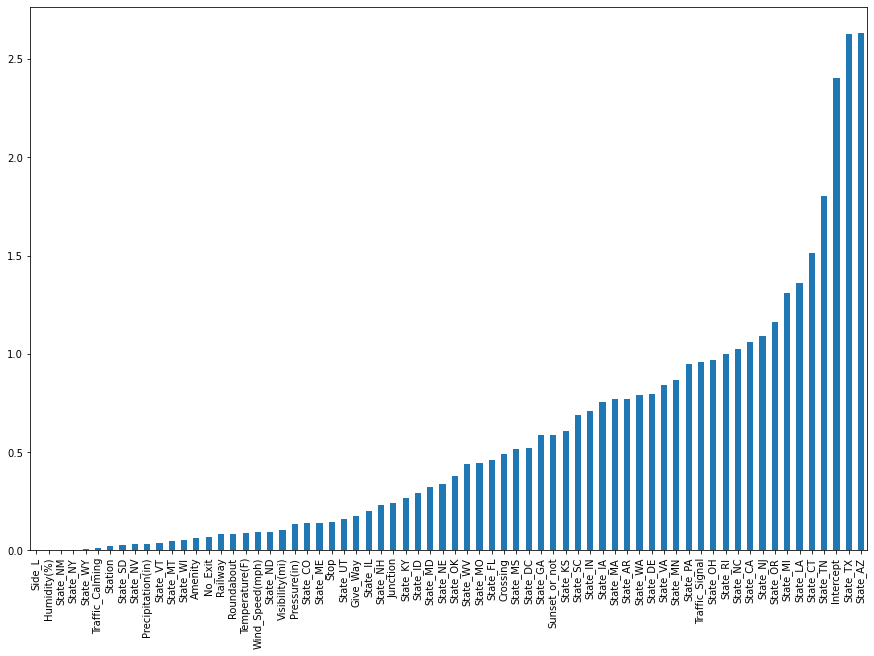

In [ ]:
plt.figure(figsize=(15,10))
coefs_grid1.loc[0].abs().sort_values().plot(kind='bar')

<AxesSubplot:>

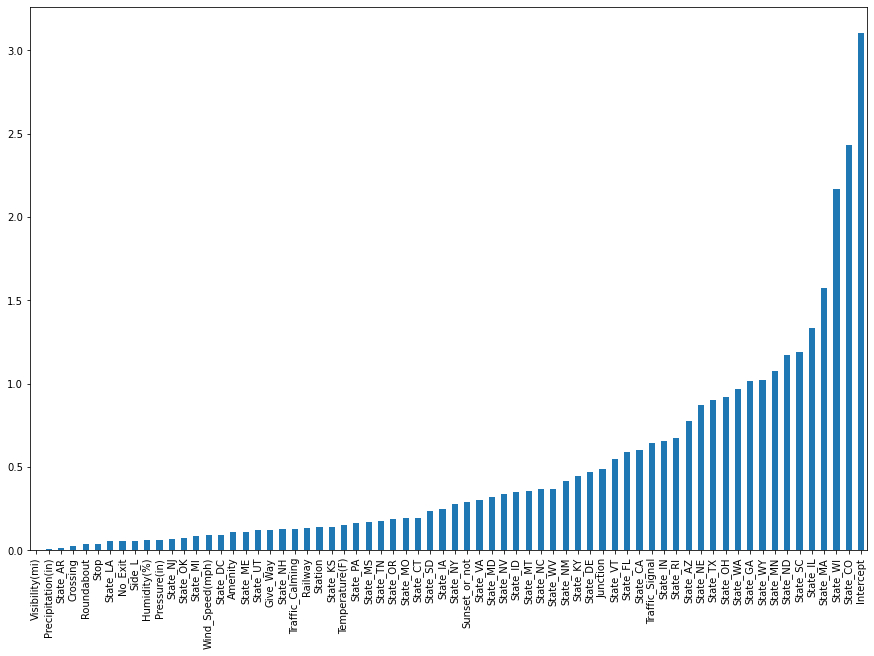

In [ ]:
plt.figure(figsize=(15,10))
coefs_grid1.loc[1].abs().sort_values().plot(kind='bar')

<AxesSubplot:>

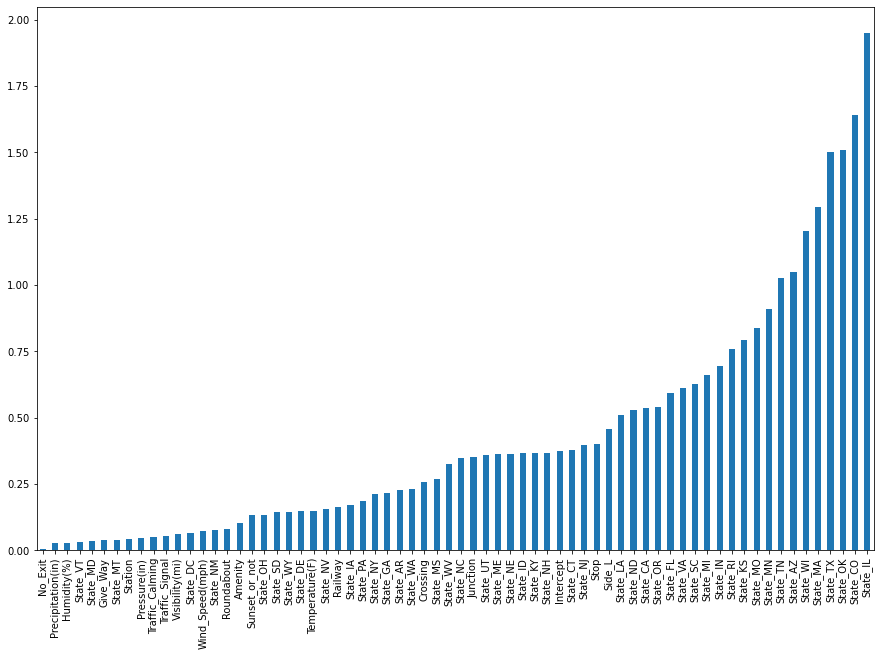

In [ ]:
plt.figure(figsize=(15,10))
coefs_grid1.loc[2].abs().sort_values().plot(kind='bar')

<AxesSubplot:>

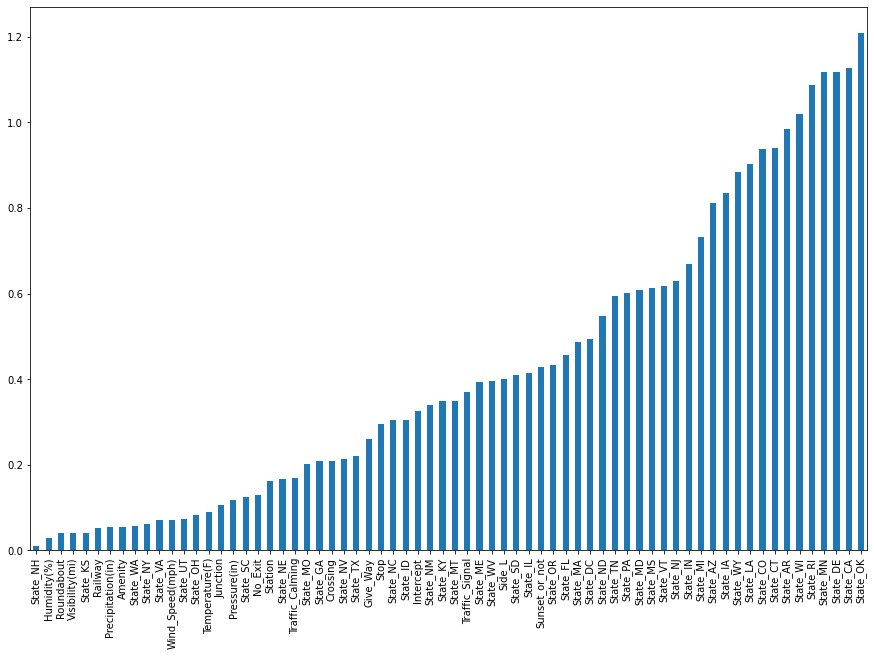

In [ ]:
plt.figure(figsize=(15,10))
coefs_grid1.loc[3].abs().sort_values().plot(kind='bar')